In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy import optimize
import scipy
import pandas as pd
from skimage import data, io, filters, feature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gc
from PIL import Image
import math
from IPython import display
from jupyterthemes import jtplot
from scipy.constants import physical_constants
import scipy.constants as constants
from scipy.integrate import solve_ivp
from numba import jit

jtplot.style(theme ='grade3', ticks=True, grid=False, fscale=1.4,figsize=(6, 4.5))
#rename these 
imgAlbum ="E:/Workspace/Python/Images/"# "E:/Workspace/Python/Images/"#
picklejar = "E:/Workspace/Python/PickleJar/"

# Define constants
amu2eV = 9.3149410242e8#eV
mass = 1.67262192e-27  # kg
kg2eV = 5.6095886e35 #ev/c^2
c = 299792458*1e3 #mm/s
charge = 1.6e-19  # C


# Beam Generation

## Knobs

In [3]:
filenum = '9-7-5e8'#name the file



#position offset
x_align = 0.0
y_align = -0.0

#particle info
num_particles = int(1e8)#determines statistics and simulation run time
mass_num = 86
kinetic_energy = 10000 #eV

#emittance
beamRad = 20
theta2_max = 0.5#degrees divergence


## Run - Time Intensive

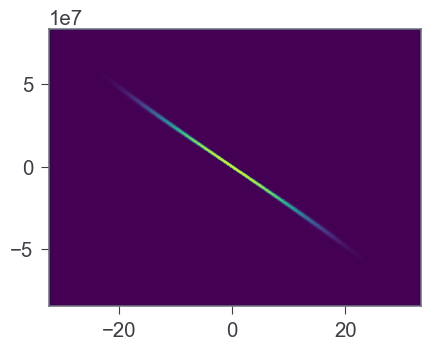

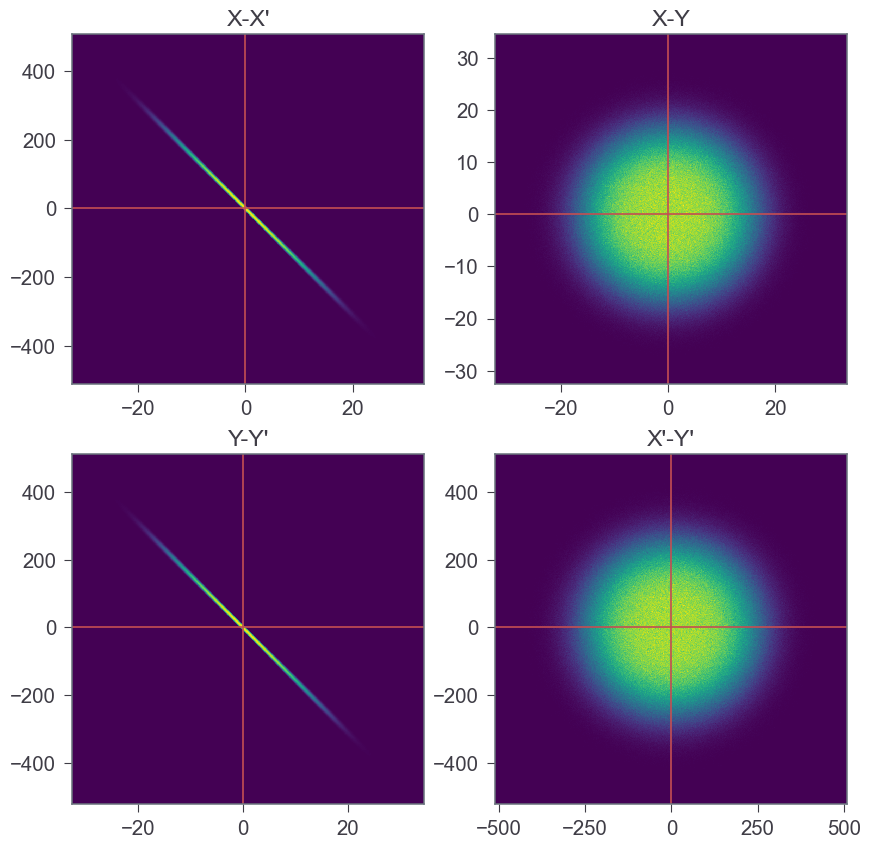

79.7803702739336
19177.51982383319
1527859.423302293
X-Emit = 14.691334704644351
Y-Emit = 14.689992709620546


42

In [4]:
theta1 = np.random.normal(0, 2*np.pi, num_particles)#position
r = np.sqrt(np.absolute(np.random.normal(0,beamRad**2/2, num_particles)))#position mm
x1 = (r * np.cos(theta1) + x_align)
y1 = (r * np.sin(theta1) + y_align)
theta2 = np.arccos(1-2*np.random.uniform(0, 0.5*(1-np.cos(theta2_max*np.pi/180)), num_particles))#np.random.normal(0,6.5e-5, num_particles)
phi = 2*np.pi*np.random.uniform(size=num_particles)#np.arccos(np.random.uniform(-1,1,num_particles))
pos_z = np.random.uniform(-0.5,0.5,num_particles)#mm
E = np.random.normal(kinetic_energy, 50, num_particles)
v = np.sqrt(2 * E / (mass_num * amu2eV))*c#mm/s

sign = np.random.uniform(size=1)*2-1
xp = (np.arctan(np.cos(phi)*np.tan(theta2)))*1000+x1*sign*np.random.normal(50*theta2_max,theta2_max*1,num_particles)#mrad np.sin(theta2)*
yp = (np.arctan(np.sin(phi)*np.tan(theta2)))*1000+y1*sign*np.random.normal(50*theta2_max,theta2_max*1,num_particles)#mrad 
zp = np.cos(theta2)#mm/s?

vx = v * np.tan(xp /1000)*zp
vy = v * np.tan(yp /1000)*zp
vz = v * zp 
tempdf = pd.DataFrame({'X':x1,'Y':y1,'Z':pos_z,'Vx':vx,'Vy':vy,'Vz':vz, 'Xp':xp,'Yp': yp})
plt.hist2d(x1,vx, bins = 1000)
plt.show()
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax[0,0].hist2d(tempdf.X, tempdf.Xp, bins = 1000)
ax[0,0].set_title("X-X'")
ax[0,0].axvline(x=0, c='r')
ax[0,0].axhline(y=0, c='r')
# ax[0,0].set_ylim(-7,7)
# ax[0,0].set_xlim(-7,7)
ax[1,0].hist2d(tempdf.Y, tempdf.Yp, bins = 1000)
ax[1,0].set_title("Y-Y'")
ax[1,0].axvline(x=0, c='r')
ax[1,0].axhline(y=0, c='r')
# ax[1,0].set_ylim(-1,1)
# ax[1,0].set_xlim(-7,7)
ax[0,1].hist2d(tempdf.X, tempdf.Y, bins = 1000)
ax[0,1].set_title("X-Y")
ax[0,1].axvline(x=0, c='r')
ax[0,1].axhline(y=0, c='r')
# ax[0,1].set_ylim(-7,7)
# ax[0,1].set_xlim(-7,7)
ax[1,1].hist2d(tempdf.Xp, tempdf.Yp, bins = 1000)
ax[1,1].set_title("X'-Y'")
ax[1,1].axvline(x=0, c='r')
ax[1,1].axhline(y=0, c='r')
# ax[1,1].set_ylim(-1,1)
# ax[1,1].set_xlim(-1,1)


tempdf.to_pickle(picklejar + f'Emittance0{filenum}.pkl')
plt.show()

print(np.mean(tempdf.X**2))
print(np.mean(tempdf.Xp**2))
print(np.mean(tempdf.X*tempdf.Xp)**2)
print(f'X-Emit = {np.sqrt(np.mean(tempdf.X**2)*np.mean(tempdf.Xp**2)-np.mean(tempdf.X*tempdf.Xp)**2)/np.pi}')
print(f'Y-Emit = {np.sqrt(np.mean(tempdf.Y**2)*np.mean(tempdf.Yp**2)-np.mean(tempdf.Y*tempdf.Yp)**2)/np.pi}')
del tempdf
gc.collect()

# Mask Simulation

## Knobs

In [5]:
hole_diameter = 127e-3 #mm
hole_separation = 0.50 #mm
mask_to_screen = 6.35#12.7 #mm
pixpermm = 20#12.5 um pores on MCP
n_holes = 59 #squared
box_start = 15.5 #mm
box_end = 15.6 #mm
target_z = box_end + mask_to_screen

## Calculation function - Run every time

In [6]:
locs2 = []
d = (hole_separation)/2*pixpermm+hole_diameter*pixpermm#pix
# print(pixpermm)
#d = (hole_separation)/2+hole_diameter
for i in range(n_holes):
    for j in range(n_holes):
        locs2.append([i*d-d*(n_holes-1)/2,j*d-(d*(n_holes-1))/2])#pix
locs2 = np.array(locs2).T
print(locs2)
@jit(nopython=True)
def motion(xi,yi,zi,vxi,vyi,vzi,t):
    zf = []
    xf = []
    yf = []
    for j in range(zi.shape[0]):#iterate over particle number
        #print(j)
        xt = xi[j]
        yt = yi[j]
        zt = zi[j]
        passed = False
        for i in range(t.shape[0]):#walk through time
        #print('Still kicking')
            zt = zi[j] + vzi[j]*t[i]
            #print(zt)
            if ((zt >= box_start) and (zt <= box_end)):#check that we are within the mask
                xt = xi[j] + vxi[j]*t[i]
                yt = yi[j] + vyi[j]*t[i]
#                 print(f'Hey Charlie! {xt}')
                for loc in range(locs2.shape[1]):#/pixpermm:#mm
                    x = locs2[0][loc]/pixpermm
                    y = locs2[1][loc]/pixpermm
#                     for x in (locs2[0])/pixpermm:
                    if ((xt - x) * (xt - x) +(yt - y) * (yt - y) <= (hole_diameter/2 * hole_diameter/2)): #check that we pass the mask
                        passed = True
#                             print(f'yay Charlie{xt}')
                        break #break out of loc loop
                    else:
#                       print(f'ono Charlie! {xt}')
                        continue
            elif(zt>box_end):
                break
            else:
                continue           
            break#break out of time
                #is xt,yt in x_box,y_box?
        if passed == True:
            for i in range(t.shape[0]):
                zt = zi[j] + vzi[j]*t[i]
                if zt >= target_z:
                    xt = xi[j] + vxi[j]*t[i]
                    yt = yi[j] + vyi[j]*t[i]
                    zf.append(zt)
                    xf.append(xt)
                    yf.append(yt)
                    break
        elif passed == False:
            xt = 9999
            yt = 9999
            zt = 9999
            zf.append(zt)
            xf.append(xt)
            yf.append(yt)
        continue
    zf = np.array(zf)
    xf = np.array(xf)
    yf = np.array(yf)
    return xf,yf,zf

[[-218.66 -218.66 -218.66 ...  218.66  218.66  218.66]
 [-218.66 -211.12 -203.58 ...  203.58  211.12  218.66]]


## Simulation Output

In [7]:
#Change these to the output (files) and input (pickles) to what you want to work with
files = [
#     'gy',
#     '9-7-5e8-20h-20p-m1',
    '9-7-1e8-20h-20p-m1'
        ]
pickles = [
#     '0y',
    #'0'
#      '9-7-5e8',
    '9-7-1e8'
        ]

### Image Generation - Time Intensive

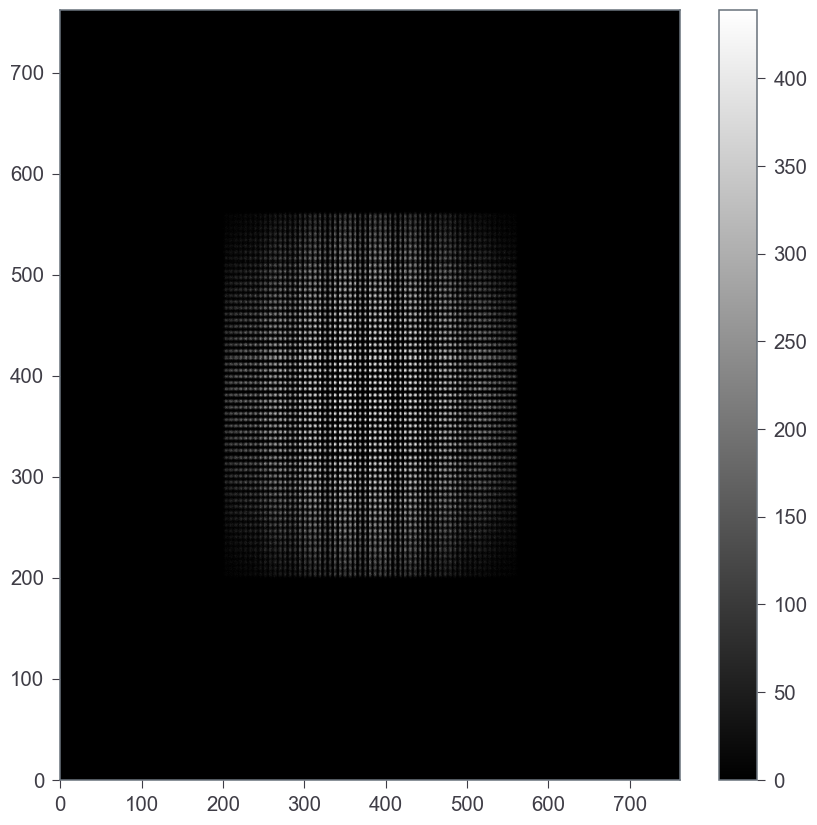

439.0
762
0.0


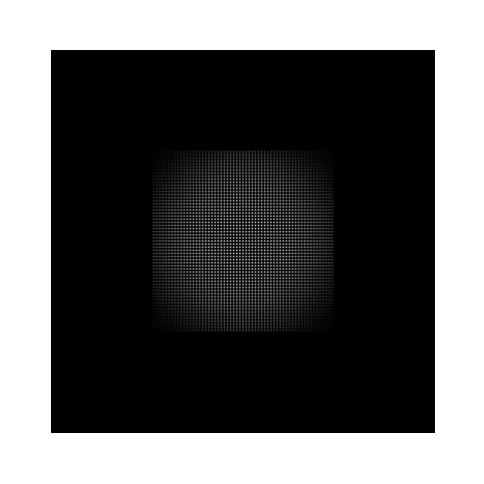

NameError: name 'folder' is not defined

In [8]:
for i in range(len(files)):
    filenum = pickles[i]
    filenum2 = files[i]
    time = 1e-6
    dt = 1e-10
    times = np.arange(0,time,dt)
    analydf = pd.read_pickle(picklejar+f'Emittance0{filenum}.pkl')
#     pixpermm = 10#12.5 um pores on MCP
    num_pix = pixpermm*25.4*1.5
#     print(num_pix)
    #simulate travel
    fin_x, fin_y, fin_z = motion(analydf.X.to_numpy(),analydf.Y.to_numpy(),analydf.Z.to_numpy(),analydf.Vx.to_numpy(),analydf.Vy.to_numpy(),analydf.Vz.to_numpy(),times[:-1])
#     print(fin_x)
    #print(fin_x[fin_x != 999])
    x_offset = num_pix/2#px
    y_offset = num_pix/2#px
#     print(x_offset)
    fin_x = fin_x[fin_y != 9999] * pixpermm +x_offset#px
    fin_y = fin_y[fin_y != 9999] * pixpermm +y_offset#px
    
    pixels = np.arange(0,num_pix+1, 1)
    plt.figure(figsize = (10,10))
    hist = plt.hist2d(fin_x, fin_y, bins=[pixels,pixels], cmap=plt.cm.gray)
    hist2, xedges, yedges = np.histogram2d(fin_x, fin_y, bins=[pixels,pixels])
    plt.colorbar()
    plt.show()
    #add noise and generate image
    noise1 = 0
    m = (255-noise1)/np.max(hist[0])
    noise = np.random.normal(noise1, np.sqrt(noise1), (len(hist[0]),len(hist[0])))
    #print(noise.shape[0])
    print(np.max(hist[0]))
    newhist = hist[0]*m #+ noise
    plt.figure(figsize = (0.98,0.98), dpi =  25.4 * pixpermm)#(2.0455,2.0455)
    print(newhist.shape[0])
    print(np.max(newhist[0]))
    plt.imshow(newhist, cmap = plt.cm.gray)
    #plt.colorbar()
    plt.axis('off')
    #filenum2 = filenum # toggle for new emit data
#     plt.savefig(imgAlbum+folder+f'simupepper-{filenum2}-h.png', bbox_inches='tight', pad_inches = 0)
    plt.show()
    np.savetxt(imgAlbum+folder+f'simupepper-{filenum2}-H.csv', hist2.T, delimiter=",")

#     np.savetxt(imgAlbum+folder+f'simupepper-{filenum2}-X.csv', xedges, delimiter=",")
#     np.savetxt(imgAlbum+folder+f'simupepper-{filenum2}-Y.csv', yedges, delimiter=",")
print(locs2[0]+x_offset)